In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from CosinorPy import file_parser, cosinor, cosinor1
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [7]:
data = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_63712\3596567331.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../PrometneNesreče.csv")


# Kosinor analiza po urah: delovnik vs. vikend

In [8]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

# Dodaj stolpca za uro in dan v tednu
data['hour'] = data['NastanekDatumCas'].dt.hour
data['weekday'] = data['NastanekDatumCas'].dt.weekday

# Razdeli dneve na delovnik in vikend
workdays = data[data['weekday'] < 5]
weekends = data[data['weekday'] >= 5]

# Preštej nesreče po urah za delovnik
accidents_per_hour_workdays = workdays['hour'].value_counts().sort_index()

# Preštej nesreče po urah za vikend
accidents_per_hour_weekend = weekends['hour'].value_counts().sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_workdays = pd.DataFrame({
    "test": "HourlyAccidents_Workdays",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour_workdays.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour_workdays.values  # Število nesreč za tisto uro
})

df_weekends = pd.DataFrame({
    "test": "HourlyAccidents_Weekends",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour_weekend.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour_weekend.values  # Število nesreč za tisto uro
})


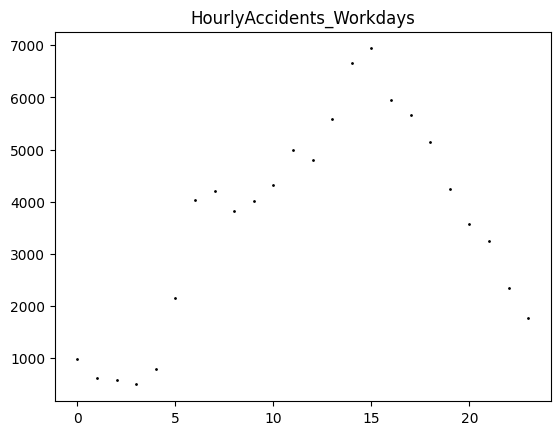

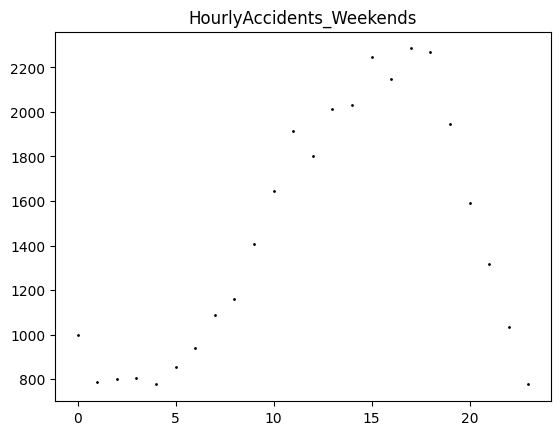

In [9]:
cosinor.plot_data(df_workdays, names = ["HourlyAccidents_Workdays"])
cosinor.plot_data(df_weekends, names = ["HourlyAccidents_Weekends"])

## Periodogram

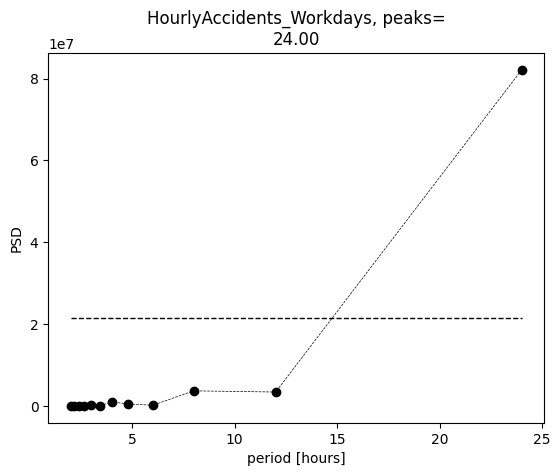

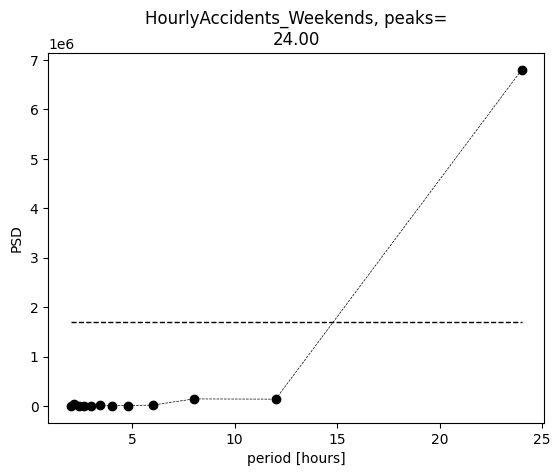

In [10]:
cosinor.periodogram_df(df_workdays)
cosinor.periodogram_df(df_weekends)

## CosinorPy

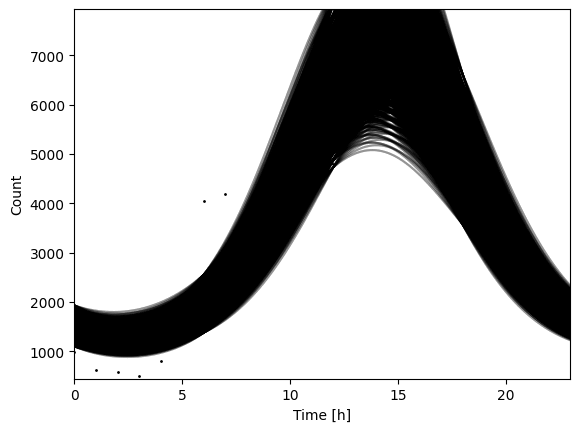

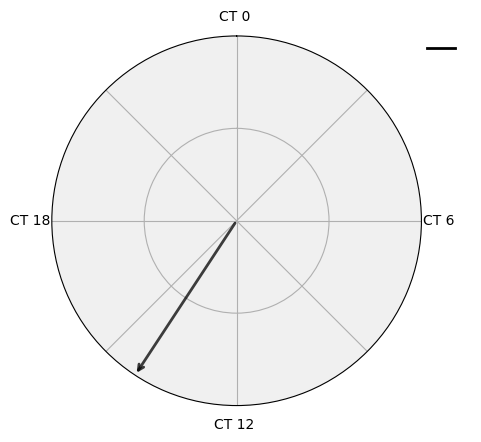

In [11]:
# DELOVNIK
X = df_workdays.x.to_numpy()
Y = df_workdays.y.to_numpy()

df_results_workdays = cosinor.fit_me(X, Y, n_components = 1, period = 24, model_type = 'gen_poisson')

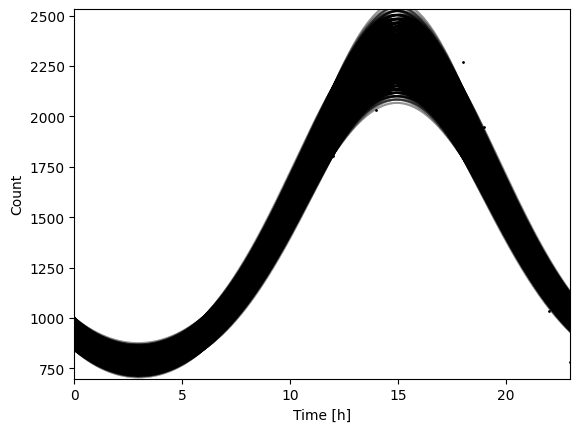

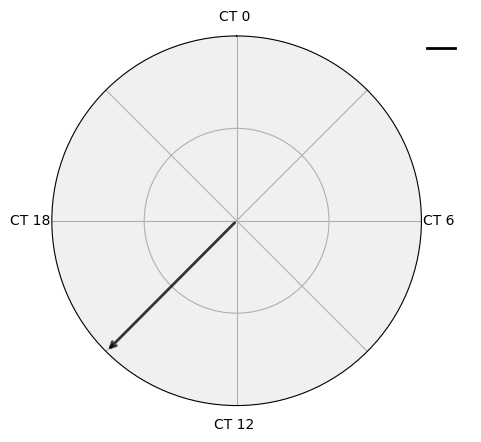

In [12]:
# VIKEND
X = df_weekends.x.to_numpy()
Y = df_weekends.y.to_numpy()

df_results_weekends = cosinor.fit_me(X, Y, n_components = 1, period = 24, model_type = 'gen_poisson')

## RhythmCount

In [18]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_workdays_RC = pd.DataFrame({
    "test": "HourlyAccidents_Workdays",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour_workdays.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour_workdays.values  # Število nesreč za tisto uro
})

df_weekends_RC = pd.DataFrame({
    "test": "HourlyAccidents_Weekends",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour_weekend.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour_weekend.values  # Število nesreč za tisto uro
})



In [14]:
count_models = ['poisson', 'zero_poisson', 'gen_poisson', 'nb', 'zero_nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

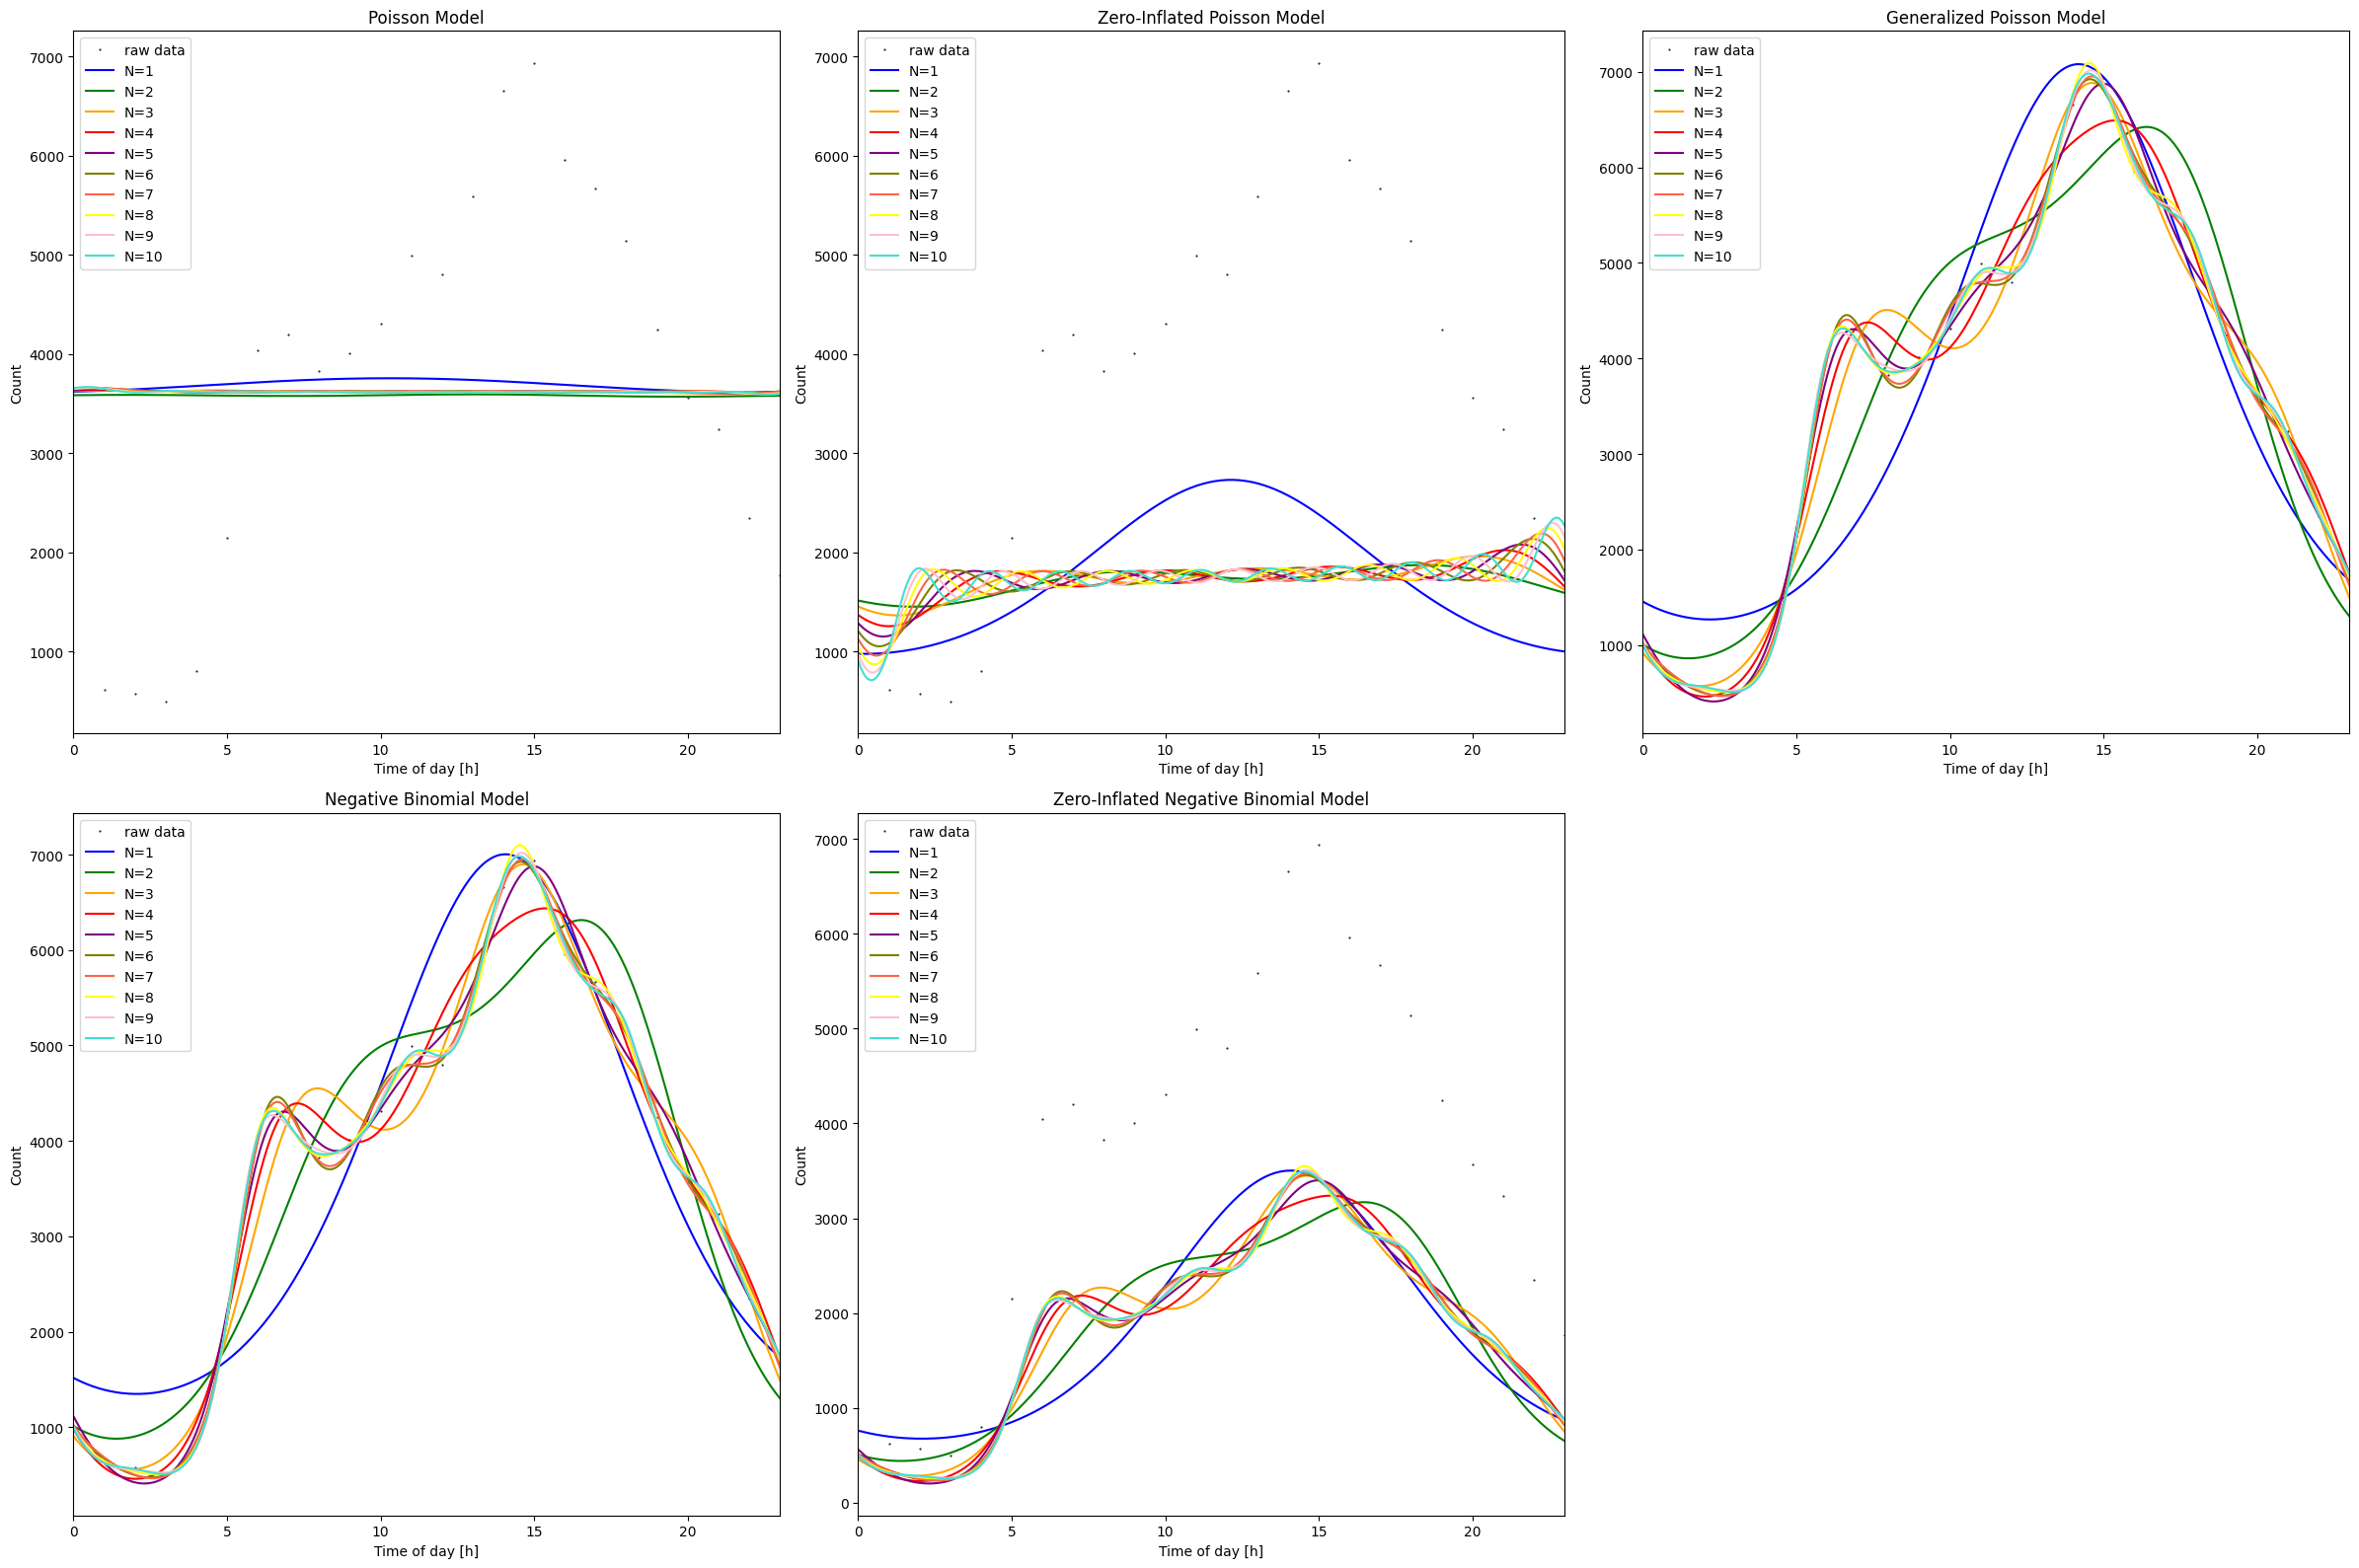

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

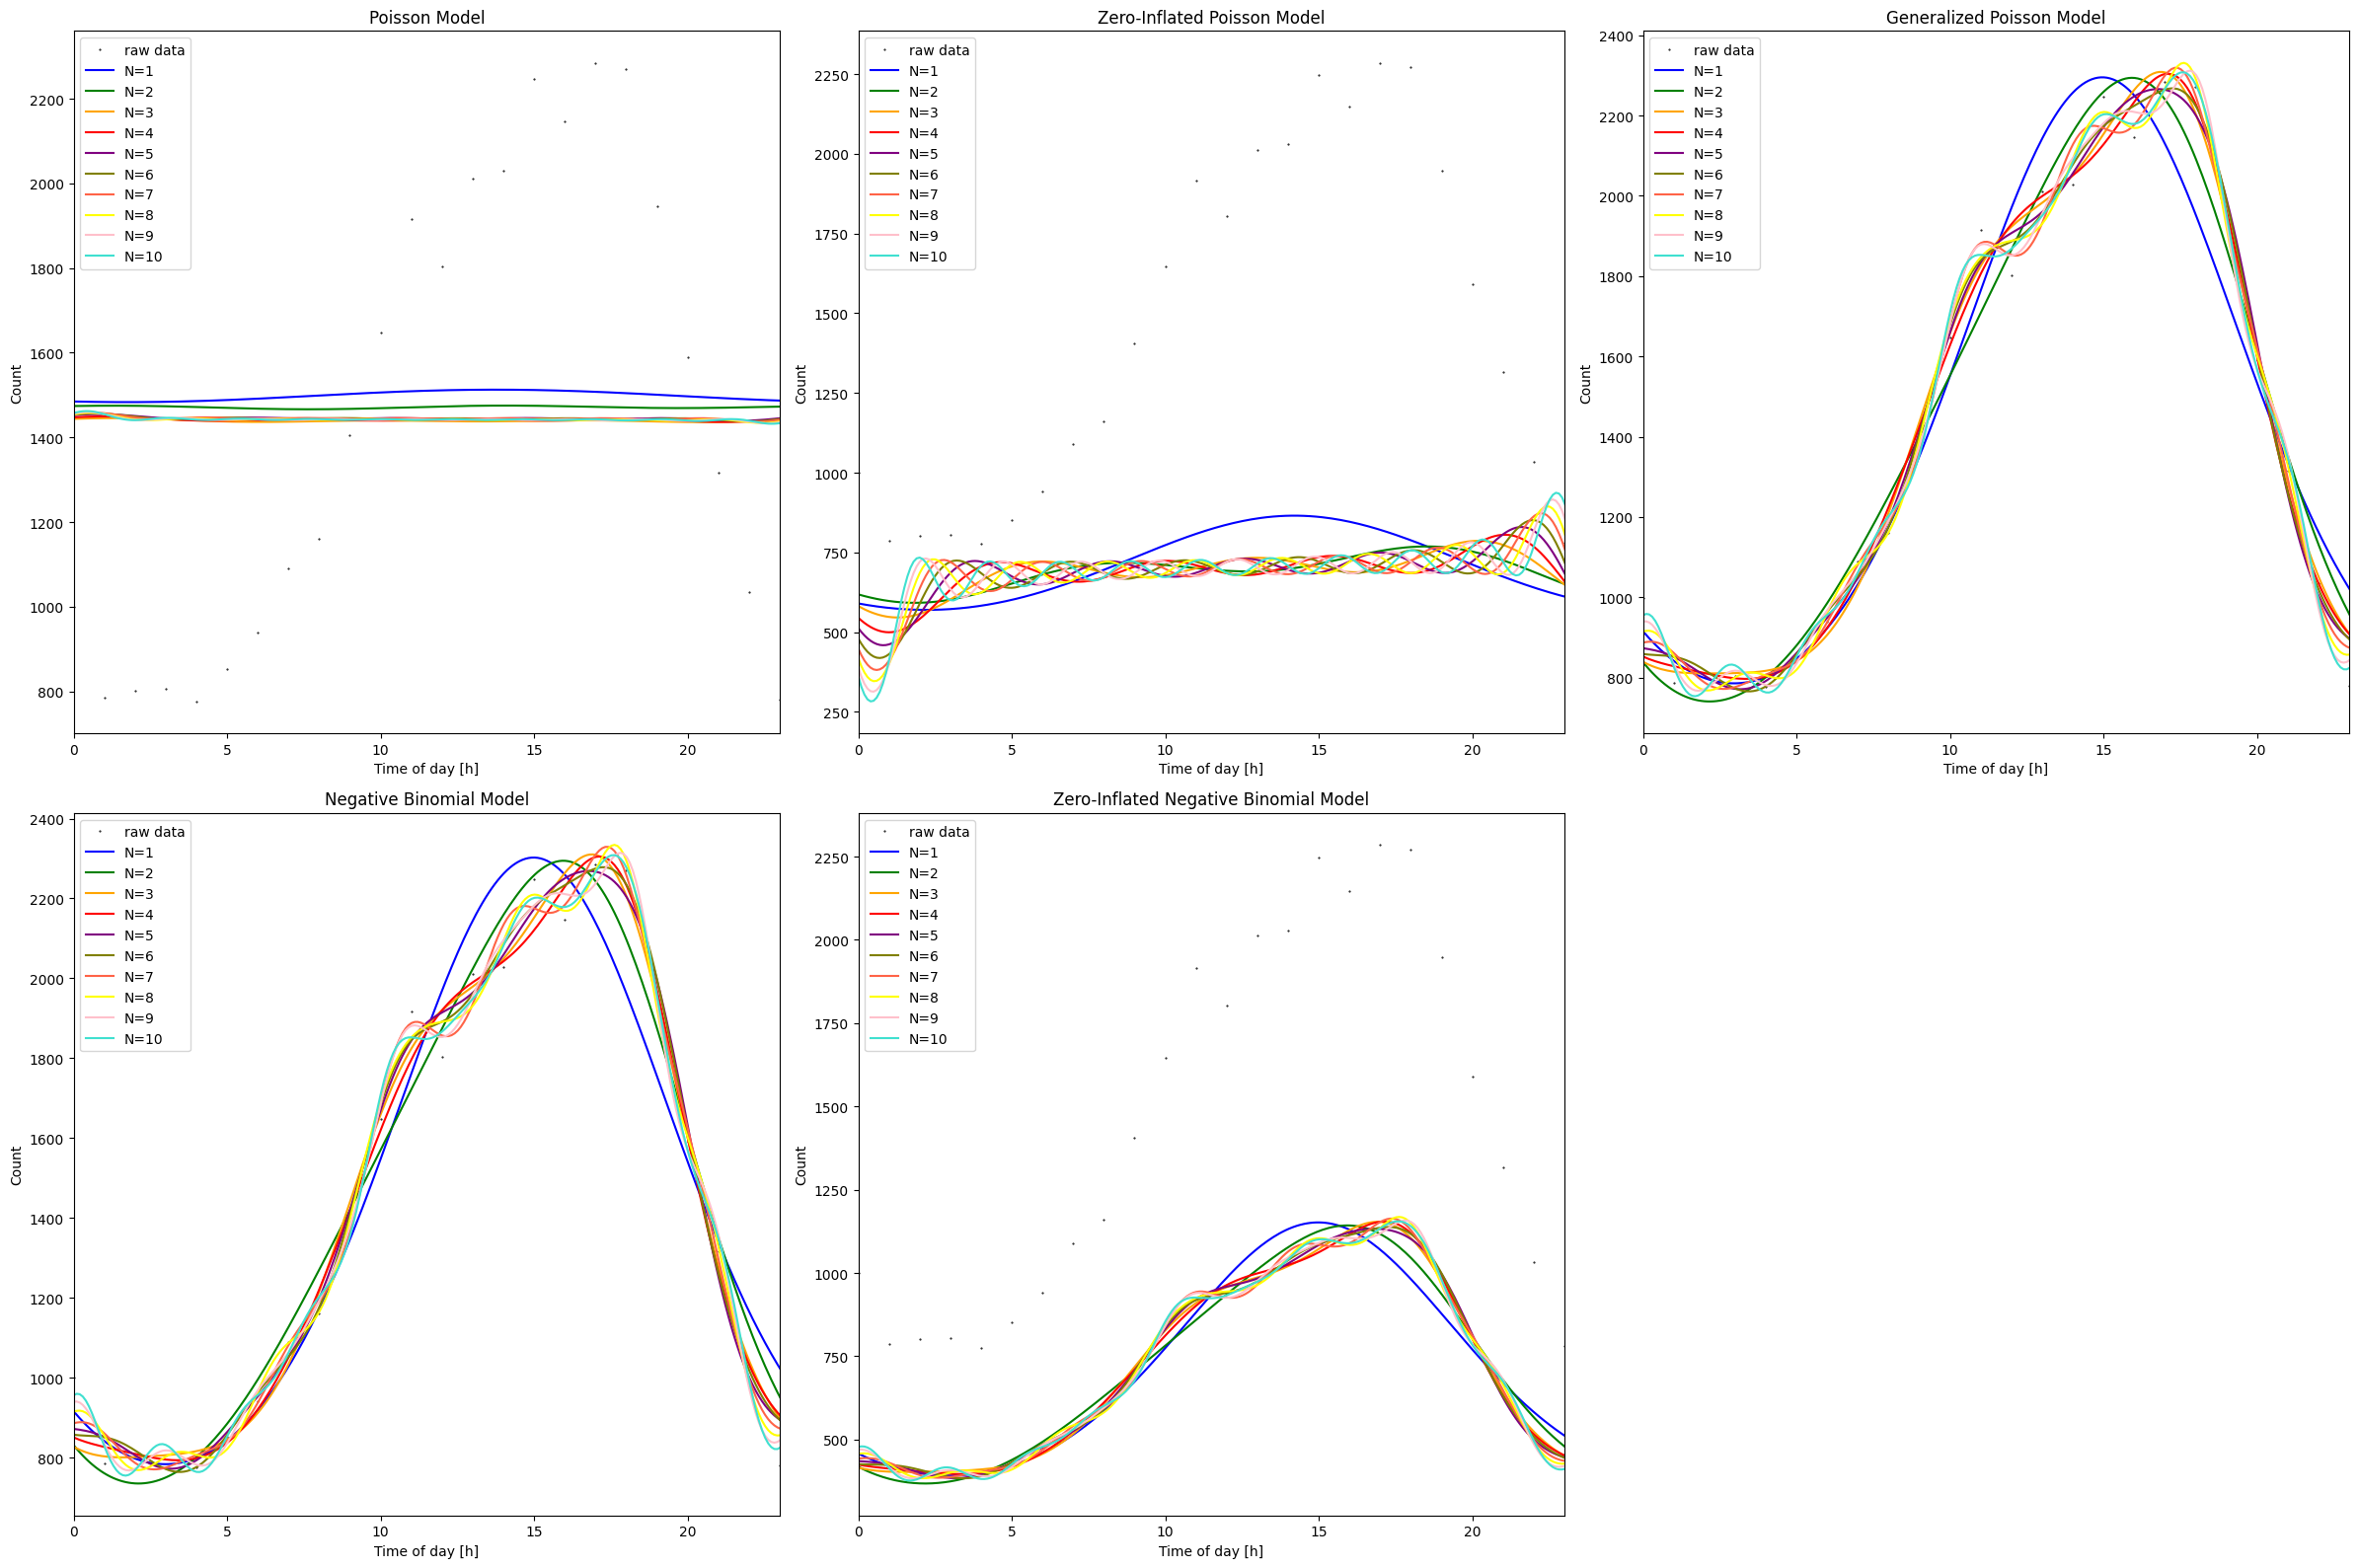

In [20]:
df_results_RC_work = dproc.fit_to_models(df_workdays_RC, count_models, n_components, 24)

df_results_RC_weekend = dproc.fit_to_models(df_weekends_RC, count_models, n_components, 24)

In [ ]:
# display(df_results_RC_work)
# display(df_results_RC_weekend)

## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [28]:
# DELOVNIK
best_count_model_work = dproc.get_best_count_model(df_results_RC_work, 'Vuong')
print("Best model: {}".format(best_count_model_work.count_model))
best_model_work = dproc.get_best_n_components(df_results_RC_work, 'Vuong', count_model=best_count_model_work['count_model'])
print("Number of components: {}".format(best_model_work.n_components))

Best model: gen_poisson
Number of components: 6


In [29]:
# VIKEND
best_count_model_weekend = dproc.get_best_count_model(df_results_RC_weekend, 'Vuong')
print("Best model: {}".format(best_count_model_weekend.count_model))
best_model_weekend = dproc.get_best_n_components(df_results_RC_weekend, 'Vuong', count_model=best_count_model_weekend['count_model'])
print("Number of components: {}".format(best_model_weekend.n_components))

Best model: gen_poisson
Number of components: 3


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [30]:
# DELOVNIK
best_n_components_work = dproc.get_best_n_components(df_results_RC_work, 'Vuong')
print("Number of components: {}".format(best_n_components_work.n_components))
best_model_work = dproc.get_best_count_model(df_results_RC_work, 'Vuong', n_components=best_n_components_work['n_components'])
print("Best model: {}".format(best_model_work.count_model))

Number of components: 6
Best model: gen_poisson


In [31]:
# VIKEND
best_n_components_weekend = dproc.get_best_n_components(df_results_RC_weekend, 'Vuong')
print("Number of components: {}".format(best_n_components_weekend.n_components))
best_model_weekend = dproc.get_best_count_model(df_results_RC_weekend, 'Vuong', n_components=best_n_components_weekend['n_components'])
print("Best model: {}".format(best_model_weekend.count_model))

Number of components: 3
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja (delovnik)

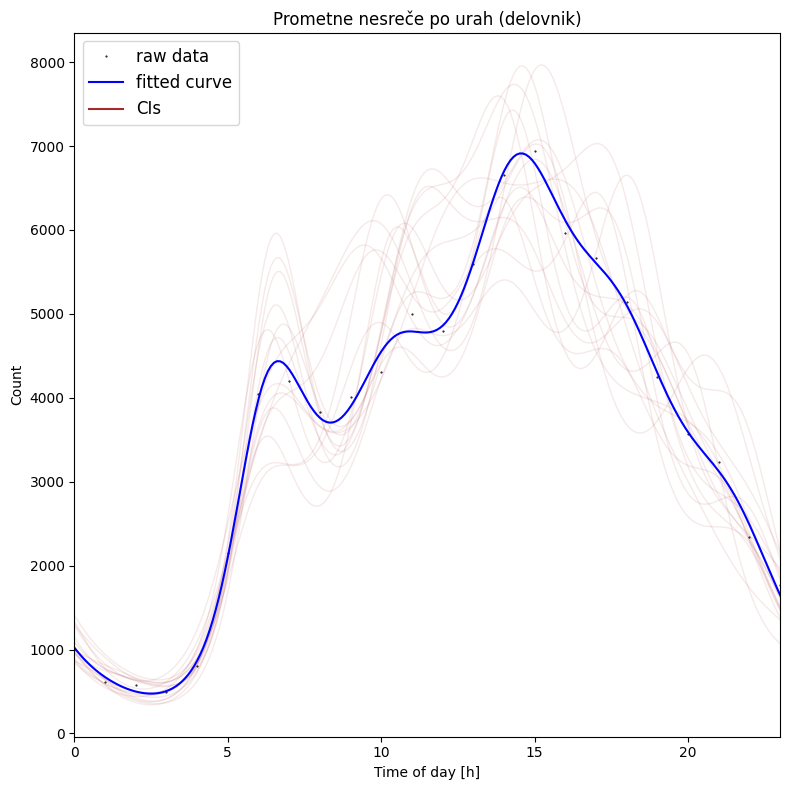

Intervali zaupanja:


,0,1
0,7.887462,8.042064
1,-0.533934,-0.418823
2,-1.021003,-0.755139
3,-0.404344,-0.248688
4,-0.365761,-0.167023
5,-0.345522,-0.192874
6,-0.009543,0.166611
7,-0.120122,0.033739
8,0.035050,0.196561
9,0.000838,0.134556


In [32]:
# DELOVNIK
count_model_work = best_model_work.count_model
n_components_work = int(best_n_components_work.n_components)

CIs_work = plot.plot_model(df_workdays_RC, count_model_work, n_components_work, title='Prometne nesreče po urah (delovnik)', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs_work)

#### Parametri izbranega modela (delovnik)

In [35]:
CIs_params_work = dproc.calculate_confidence_intervals_parameters(df_workdays_RC, n_components_work, count_model_work, best_model_work['peaks'])
best_model_work = pd.concat([best_model_work, pd.Series(CIs_params_work)], axis=0)
best_model_work=best_model_work[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model_work.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,3226.77
mesor,3697.36
peaks,[14.61]
heights,[6924.13]
amplitude_CIs,"[3114.67, 3336.56]"
mesor_CIs,"[3568.82, 3808.61]"
peaks_CIs,"[14.02, 15.1]"
heights_CIs,"[6699.25, 7129.42]"


### Prikaz najboljšega modela skupaj z intervali zaupanja (vikend)

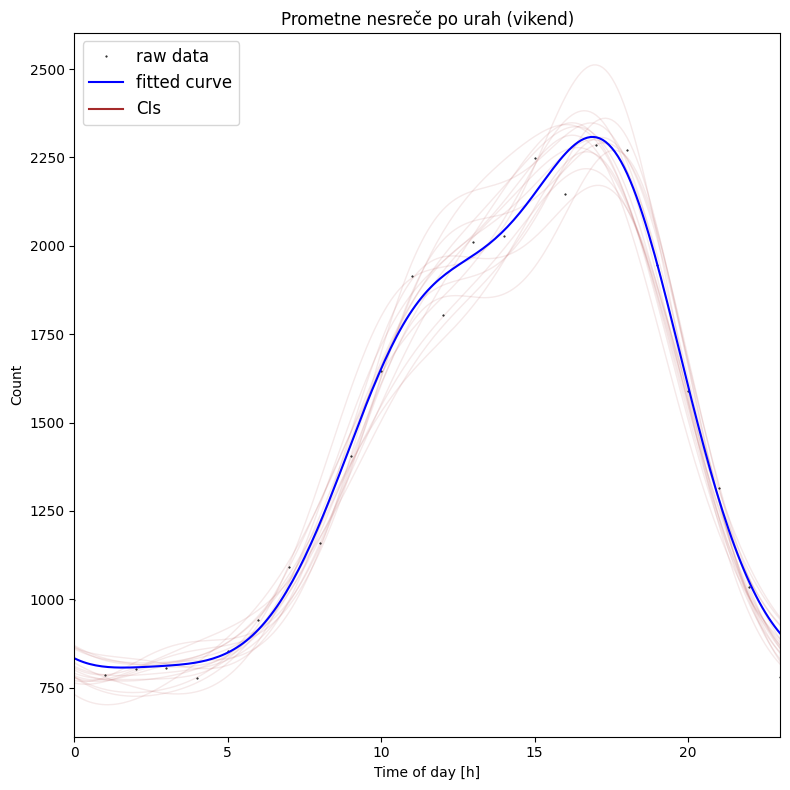

Intervali zaupanja:


,0,1
0,7.177401,7.220134
1,-0.388818,-0.350647
2,-0.455980,-0.358162
3,-0.042358,0.018262
4,-0.105924,-0.018951
5,0.041970,0.093797
6,-0.064788,0.021691
7,-0.098821,1.252893


In [34]:
# VIKEND
count_model_weekend = best_model_weekend.count_model
n_components_weekend = int(best_n_components_weekend.n_components)

CIs_weekend = plot.plot_model(df_weekends_RC, count_model_weekend, n_components_weekend, title='Prometne nesreče po urah (vikend)', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs_weekend)

#### Parametri izbranega modela (vikend)

In [36]:
CIs_params_weekend = dproc.calculate_confidence_intervals_parameters(df_weekends_RC, n_components_weekend, count_model_weekend, best_model_weekend['peaks'])
best_model_weekend = pd.concat([best_model_weekend, pd.Series(CIs_params_weekend)], axis=0)
best_model_weekend=best_model_weekend[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model_weekend.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,3
amplitude,749.11
mesor,1559.49
peaks,[16.92]
heights,[2308.61]
amplitude_CIs,"[708.1, 817.59]"
mesor_CIs,"[1497.74, 1614.46]"
peaks_CIs,"[16.52, 17.17]"
heights_CIs,"[2218.52, 2419.38]"


### Na istem grafu

In [37]:
combined_df = pd.concat([df_workdays_RC, df_weekends_RC], axis=0, ignore_index=True)

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

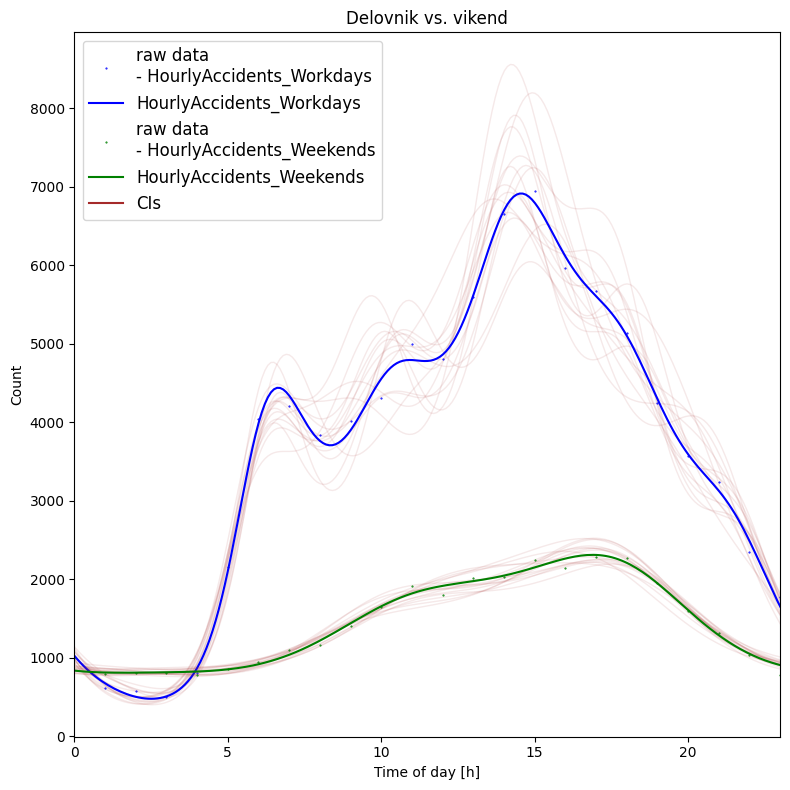

In [42]:
df_results_combined = dproc.compare_by_component(combined_df, 'test', n_components, count_models, ax_indices=[1, 1],
                           ax_titles=['Delovnik vs. vikend'], rows=1, cols=1)

In [43]:
display(df_results_combined)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,...,Y(est),X_test,Y_test,test,amplitude_CIs,mesor_CIs,peaks_CIs,heights_CIs,CIs_model_params_0,CIs_model_params_1
0,gen_poisson,6,3218.6,3693.21,[14.51],[6911.8],2.053822e-26,258832.302686,316.614789,333.107542,...,"[1021.5930613247091, 671.1399127332005, 499.34...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1021.5930613247091, 975.6545674325915, 932.51...",HourlyAccidents_Workdays,"[2805.85, 3587.68]","[3290.66, 4057.15]","[13.73, 15.54]","[6101.25, 7640.09]","{0: 7.9196613921633725, 1: -0.5315319325894269...","{0: 7.988733176424289, 1: -0.4264956746223019,..."
1,gen_poisson,3,750.7,1557.40,[16.92],[2308.1],7.165617e-19,105861.469622,287.029570,296.454000,...,"[832.952152277393, 809.0480158012647, 807.4034...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[832.952152277393, 828.8843116429031, 825.2592...",HourlyAccidents_Weekends,"[722.68, 806.71]","[1498.43, 1613.95]","[16.51, 17.29]","[2230.99, 2410.78]","{0: 7.167809080388135, 1: -0.39143273035375187...","{0: 7.232230224486905, 1: -0.3480439836373695,..."
